In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Core ML libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, 
    BatchNormalization, Concatenate, Flatten, Attention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Feature selection
from boruta import BorutaPy

# Technical indicators - custom implementations
from scipy import stats

# Sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
class BitcoinPricePredictor:
    def __init__(self, lookback_window=60, prediction_horizon=1):
        """
        Initialize the Bitcoin Price Predictor
        
        Args:
            lookback_window: Number of historical periods to look back
            prediction_horizon: Number of periods to predict ahead
        """
        self.lookback_window = lookback_window
        self.prediction_horizon = prediction_horizon
        self.scaler = MinMaxScaler()
        self.feature_scaler = MinMaxScaler()
        self.model = None
        self.selected_features = None
        self.feature_names = None
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        
    def calculate_rsi(self, prices, period=14):
        """Calculate RSI (Relative Strength Index)"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_ema(self, prices, period):
        """Calculate Exponential Moving Average"""
        return prices.ewm(span=period, adjust=False).mean()
    
    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD (Moving Average Convergence Divergence)"""
        ema_fast = self.calculate_ema(prices, fast)
        ema_slow = self.calculate_ema(prices, slow)
        macd = ema_fast - ema_slow
        macd_signal = self.calculate_ema(macd, signal)
        macd_hist = macd - macd_signal
        return macd, macd_signal, macd_hist
    
    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper = sma + (std * std_dev)
        lower = sma - (std * std_dev)
        return upper, sma, lower
    
    def calculate_stochastic(self, high, low, close, k_period=14, d_period=3):
        """Calculate Stochastic Oscillator"""
        lowest_low = low.rolling(window=k_period).min()
        highest_high = high.rolling(window=k_period).max()
        k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
        d_percent = k_percent.rolling(window=d_period).mean()
        return k_percent, d_percent
    
    def calculate_williams_r(self, high, low, close, period=14):
        """Calculate Williams %R"""
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        williams_r = -100 * (highest_high - close) / (highest_high - lowest_low)
        return williams_r
    
    def calculate_atr(self, high, low, close, period=14):
        """Calculate Average True Range"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())
        true_range = np.maximum(high_low, np.maximum(high_close, low_close))
        atr = true_range.rolling(window=period).mean()
        return atr
    
    def calculate_adx(self, high, low, close, period=14):
        """Calculate ADX (Average Directional Index)"""
        # Calculate True Range
        tr = self.calculate_atr(high, low, close, 1)
        
        # Calculate Directional Movements
        up_move = high - high.shift()
        down_move = low.shift() - low
        
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
        
        plus_dm = pd.Series(plus_dm, index=high.index)
        minus_dm = pd.Series(minus_dm, index=low.index)
        
        # Calculate Directional Indicators
        plus_di = 100 * (plus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
        minus_di = 100 * (minus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
        
        # Calculate ADX
        dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
        adx = dx.rolling(window=period).mean()
        
        return adx
    
    def calculate_cci(self, high, low, close, period=20):
        """Calculate CCI (Commodity Channel Index)"""
        typical_price = (high + low + close) / 3
        sma_tp = typical_price.rolling(window=period).mean()
        mad = typical_price.rolling(window=period).apply(lambda x: np.mean(np.abs(x - x.mean())), raw=True)
        cci = (typical_price - sma_tp) / (0.015 * mad)
        return cci
    
    def calculate_mfi(self, high, low, close, volume, period=14):
        """Calculate MFI (Money Flow Index)"""
        typical_price = (high + low + close) / 3
        money_flow = typical_price * volume
        
        # Positive and negative money flow
        positive_flow = money_flow.where(typical_price > typical_price.shift(), 0)
        negative_flow = money_flow.where(typical_price < typical_price.shift(), 0)
        
        # Money flow ratio
        positive_mf = positive_flow.rolling(window=period).sum()
        negative_mf = negative_flow.rolling(window=period).sum()
        mfr = positive_mf / negative_mf
        
        # Money flow index
        mfi = 100 - (100 / (1 + mfr))
        return mfi
    
    def calculate_obv(self, close, volume):
        """Calculate OBV (On Balance Volume)"""
        obv = (np.sign(close.diff()) * volume).fillna(0).cumsum()
        return obv
    
    def create_technical_indicators(self, df):
        """Create comprehensive technical indicators"""
        technical_df = df.copy()
        
        # Price-based indicators
        technical_df['rsi'] = self.calculate_rsi(df['close'], 14)
        technical_df['rsi_30'] = self.calculate_rsi(df['close'], 30)
        
        # Moving averages
        technical_df['sma_10'] = df['close'].rolling(window=10).mean()
        technical_df['sma_20'] = df['close'].rolling(window=20).mean()
        technical_df['sma_50'] = df['close'].rolling(window=50).mean()
        technical_df['ema_12'] = self.calculate_ema(df['close'], 12)
        technical_df['ema_26'] = self.calculate_ema(df['close'], 26)
        
        # MACD
        macd, macd_signal, macd_hist = self.calculate_macd(df['close'])
        technical_df['macd'] = macd
        technical_df['macd_signal'] = macd_signal
        technical_df['macd_hist'] = macd_hist
        
        # Bollinger Bands
        bb_upper, bb_middle, bb_lower = self.calculate_bollinger_bands(df['close'])
        technical_df['bb_upper'] = bb_upper
        technical_df['bb_middle'] = bb_middle
        technical_df['bb_lower'] = bb_lower
        technical_df['bb_width'] = (bb_upper - bb_lower) / bb_middle
        technical_df['bb_position'] = (df['close'] - bb_lower) / (bb_upper - bb_lower)
        
        # Stochastic
        stoch_k, stoch_d = self.calculate_stochastic(df['high'], df['low'], df['close'])
        technical_df['stoch_k'] = stoch_k
        technical_df['stoch_d'] = stoch_d
        
        # Williams %R
        technical_df['williams_r'] = self.calculate_williams_r(df['high'], df['low'], df['close'])
        
        # ADX
        technical_df['adx'] = self.calculate_adx(df['high'], df['low'], df['close'])
        
        # Commodity Channel Index
        technical_df['cci'] = self.calculate_cci(df['high'], df['low'], df['close'])
        
        # Average True Range
        technical_df['atr'] = self.calculate_atr(df['high'], df['low'], df['close'])
        
        # Money Flow Index
        technical_df['mfi'] = self.calculate_mfi(df['high'], df['low'], df['close'], df['volume'])
        
        # On Balance Volume
        technical_df['obv'] = self.calculate_obv(df['close'], df['volume'])
        
        # Price ratios and changes
        technical_df['price_change'] = df['close'].pct_change()
        technical_df['price_change_2'] = df['close'].pct_change(2)
        technical_df['price_change_5'] = df['close'].pct_change(5)
        technical_df['high_low_ratio'] = df['high'] / df['low']
        technical_df['close_open_ratio'] = df['close'] / df['open']
        
        # Volume indicators
        technical_df['volume_sma'] = df['volume'].rolling(window=20).mean()
        technical_df['volume_ratio'] = df['volume'] / technical_df['volume_sma']
        
        # Volatility measures
        technical_df['volatility'] = df['close'].rolling(window=20).std()
        technical_df['volatility_ratio'] = technical_df['volatility'] / technical_df['volatility'].rolling(window=50).mean()
        
        # Support and resistance levels
        technical_df['support'] = df['low'].rolling(window=20).min()
        technical_df['resistance'] = df['high'].rolling(window=20).max()
        technical_df['support_distance'] = (df['close'] - technical_df['support']) / df['close']
        technical_df['resistance_distance'] = (technical_df['resistance'] - df['close']) / df['close']
        
        # Additional momentum indicators
        technical_df['momentum'] = df['close'] / df['close'].shift(10)
        technical_df['roc'] = df['close'].pct_change(10)  # Rate of Change
        
        # Price position indicators
        technical_df['price_position'] = (df['close'] - df['low'].rolling(window=20).min()) / (df['high'].rolling(window=20).max() - df['low'].rolling(window=20).min())
        
        # Volume-Price Trend
        technical_df['vpt'] = (df['volume'] * df['close'].pct_change()).cumsum()
        
        # Money Flow
        technical_df['money_flow'] = df['volume'] * ((df['high'] + df['low'] + df['close']) / 3)
        
        return technical_df
    
    def create_market_microstructure_features(self, ohlcv_df, funding_df, oi_df):
        """Create market microstructure features"""
        df = ohlcv_df.copy()
        
        # Ensure datetime index
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        
        # Merge funding rates
        if funding_df is not None and not funding_df.empty:
            # Align funding data with OHLCV data using index
            funding_aligned = funding_df.reindex(df.index)
            df['funding_rate'] = funding_aligned['funding_rate'].fillna(method='ffill')
            df['funding_rate_change'] = df['funding_rate'].pct_change()
            df['funding_rate_ma'] = df['funding_rate'].rolling(window=24).mean()
            
            # Additional funding rate features
            df['funding_rate_std'] = df['funding_rate'].rolling(window=24).std()
            df['funding_rate_zscore'] = (df['funding_rate'] - df['funding_rate_ma']) / df['funding_rate_std']
        
        # Merge open interest
        if oi_df is not None and not oi_df.empty:
            # Align OI data with OHLCV data using index
            oi_aligned = oi_df.reindex(df.index)
            df['close_settlement'] = oi_aligned['close_settlement'].fillna(method='ffill')
            df['close_quote'] = oi_aligned['close_quote'].fillna(method='ffill')
            
            # OI-based features
            df['oi_change'] = df['close_settlement'].pct_change()
            df['oi_volume_ratio'] = df['close_settlement'] / df['volume']
            df['oi_price_ratio'] = df['close_settlement'] / df['close']
            df['oi_quote_settlement_ratio'] = df['close_quote'] / df['close_settlement']
            
            # OI momentum and volatility
            df['oi_momentum'] = df['close_settlement'] / df['close_settlement'].shift(24)
            df['oi_volatility'] = df['close_settlement'].rolling(window=24).std()
        
        # Time-based features using datetime index
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['day_of_month'] = df.index.day
        df['week_of_year'] = df.index.isocalendar().week
        
        # Cyclical encoding for time features
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
        df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
        
        # Market session indicators (assuming UTC time)
        df['is_asian_session'] = ((df['hour'] >= 1) & (df['hour'] <= 9)).astype(int)
        df['is_london_session'] = ((df['hour'] >= 8) & (df['hour'] <= 17)).astype(int)
        df['is_ny_session'] = ((df['hour'] >= 13) & (df['hour'] <= 22)).astype(int)
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        
        return df
    
    def analyze_sentiment(self, news_df):
        """Analyze sentiment from news data"""
        if news_df is None or news_df.empty:
            return pd.DataFrame()
        
        news_df = news_df.copy()
        
        # Ensure date column is datetime
        if 'date' in news_df.columns:
            news_df['date'] = pd.to_datetime(news_df['date'])
        
        sentiment_data = []
        
        for _, row in news_df.iterrows():
            # Handle missing values
            title = str(row['title']) if pd.notna(row['title']) else ""
            description = str(row['description']) if pd.notna(row['description']) else ""
            text = f"{title} {description}".strip()
            
            if not text:
                continue
                
            # VADER sentiment
            vader_scores = self.sentiment_analyzer.polarity_scores(text)
            
            # TextBlob sentiment
            try:
                blob = TextBlob(text)
                polarity = blob.sentiment.polarity
                subjectivity = blob.sentiment.subjectivity
            except:
                polarity = 0.0
                subjectivity = 0.0
            
            sentiment_data.append({
                'date': row['date'],
                'vader_compound': vader_scores['compound'],
                'vader_pos': vader_scores['pos'],
                'vader_neg': vader_scores['neg'],
                'vader_neu': vader_scores['neu'],
                'textblob_polarity': polarity,
                'textblob_subjectivity': subjectivity,
                'news_count': 1
            })
        
        if not sentiment_data:
            return pd.DataFrame()
            
        sentiment_df = pd.DataFrame(sentiment_data)
        
        # Aggregate daily sentiment
        daily_sentiment = sentiment_df.groupby(sentiment_df['date'].dt.date).agg({
            'vader_compound': ['mean', 'std', 'min', 'max'],
            'vader_pos': ['mean', 'std'],
            'vader_neg': ['mean', 'std'],
            'vader_neu': 'mean',
            'textblob_polarity': ['mean', 'std', 'min', 'max'],
            'textblob_subjectivity': ['mean', 'std'],
            'news_count': 'sum'
        }).reset_index()
        
        # Flatten column names
        daily_sentiment.columns = ['date'] + [f"{col[0]}_{col[1]}" if col[1] else col[0] 
                                            for col in daily_sentiment.columns[1:]]
        
        daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
        
        # Fill NaN std values with 0
        std_cols = [col for col in daily_sentiment.columns if 'std' in col]
        daily_sentiment[std_cols] = daily_sentiment[std_cols].fillna(0)
        
        return daily_sentiment
    
    def prepare_features(self, ohlcv_df, funding_df=None, oi_df=None, news_df=None):
        """Prepare comprehensive feature set"""
        print("Creating technical indicators...")
        df = self.create_technical_indicators(ohlcv_df)
        
        print("Creating market microstructure features...")
        df = self.create_market_microstructure_features(df, funding_df, oi_df)
        
        print("Analyzing sentiment...")
        if news_df is not None and not news_df.empty:
            sentiment_df = self.analyze_sentiment(news_df)
            if not sentiment_df.empty:
                # Merge sentiment data using the date
                df_with_date = df.copy()
                df_with_date['date'] = df_with_date.index.date
                df_with_date['date'] = pd.to_datetime(df_with_date['date'])
                
                df = df_with_date.merge(sentiment_df, on='date', how='left')
                df = df.drop('date', axis=1)
                
                # Fill missing sentiment values
                sentiment_cols = [col for col in df.columns if 'vader' in col or 'textblob' in col or 'news_count' in col]
                df[sentiment_cols] = df[sentiment_cols].fillna(0)
        
        # Create lag features
        price_cols = ['close', 'high', 'low', 'open', 'volume']
        for col in price_cols:
            if col in df.columns:
                for lag in [1, 2, 3, 5, 10]:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
        
        # Rolling statistics
        for window in [5, 10, 20]:
            df[f'close_rolling_mean_{window}'] = df['close'].rolling(window=window).mean()
            df[f'close_rolling_std_{window}'] = df['close'].rolling(window=window).std()
            df[f'volume_rolling_mean_{window}'] = df['volume'].rolling(window=window).mean()
            df[f'high_rolling_max_{window}'] = df['high'].rolling(window=window).max()
            df[f'low_rolling_min_{window}'] = df['low'].rolling(window=window).min()
        
        # Cross-sectional features
        df['close_vs_sma20'] = df['close'] / df['sma_20']
        df['close_vs_ema12'] = df['close'] / df['ema_12']
        df['volume_vs_sma20'] = df['volume'] / df['volume_sma']
        
        # Percentile features
        for window in [20, 50]:
            df[f'close_percentile_{window}'] = df['close'].rolling(window=window).rank(pct=True)
            df[f'volume_percentile_{window}'] = df['volume'].rolling(window=window).rank(pct=True)
        
        # Remove rows with NaN values
        initial_rows = len(df)
        df = df.dropna()
        final_rows = len(df)
        
        print(f"Removed {initial_rows - final_rows} rows with NaN values")
        print(f"Final dataset shape: {df.shape}")
        
        return df
    
    def select_features_boruta(self, X, y, max_iter=100, random_state=42):
        """Select features using Boruta algorithm"""
        print("Running Boruta feature selection...")
        
        # Initialize Boruta
        rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
        boruta = BorutaPy(rf, n_estimators='auto', max_iter=max_iter, 
                         random_state=random_state, verbose=2)
        
        # Fit Boruta
        boruta.fit(X.values, y.values)
        
        # Get selected features
        selected_features = X.columns[boruta.support_].tolist()
        
        print(f"Selected {len(selected_features)} features out of {X.shape[1]} total features")
        print("Selected features:", selected_features[:10], "..." if len(selected_features) > 10 else "")
        
        return selected_features, boruta
    
    def create_sequences(self, data, target_col='close'):
        """Create sequences for CNN-LSTM model"""
        X, y = [], []
        
        for i in range(self.lookback_window, len(data) - self.prediction_horizon + 1):
            X.append(data[i-self.lookback_window:i])
            y.append(data[i:i+self.prediction_horizon][target_col])
        
        return np.array(X), np.array(y)
    
    def build_cnn_lstm_model(self, input_shape, num_features):
        """Build hybrid CNN-LSTM model with attention"""
        
        # Input layer
        input_layer = Input(shape=input_shape)
        
        # CNN layers for pattern recognition
        conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
        conv1 = BatchNormalization()(conv1)
        conv1 = Dropout(0.2)(conv1)
        
        conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Dropout(0.2)(conv2)
        
        conv3 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv2)
        conv3 = BatchNormalization()(conv3)
        conv3 = MaxPooling1D(pool_size=2)(conv3)
        conv3 = Dropout(0.2)(conv3)
        
        # LSTM layers for temporal dependencies
        lstm1 = LSTM(100, return_sequences=True)(conv3)
        lstm1 = BatchNormalization()(lstm1)
        lstm1 = Dropout(0.3)(lstm1)
        
        lstm2 = LSTM(50, return_sequences=True)(lstm1)
        lstm2 = BatchNormalization()(lstm2)
        lstm2 = Dropout(0.3)(lstm2)
        
        lstm3 = LSTM(25, return_sequences=False)(lstm2)
        lstm3 = BatchNormalization()(lstm3)
        lstm3 = Dropout(0.3)(lstm3)
        
        # Dense layers
        dense1 = Dense(50, activation='relu')(lstm3)
        dense1 = BatchNormalization()(dense1)
        dense1 = Dropout(0.2)(dense1)
        
        dense2 = Dense(25, activation='relu')(dense1)
        dense2 = BatchNormalization()(dense2)
        dense2 = Dropout(0.2)(dense2)
        
        # Output layer
        output = Dense(self.prediction_horizon, activation='linear')(dense2)
        
        # Create model
        model = Model(inputs=input_layer, outputs=output)
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def train_model(self, df, target_col='close', validation_split=0.2, epochs=100, batch_size=32):
        """Train the CNN-LSTM model"""
        
        # Prepare features (exclude any remaining non-numeric columns)
        exclude_cols = [col for col in df.columns if col in [target_col] or df[col].dtype == 'object']
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        
        X = df[feature_cols]
        y = df[target_col]
        
        print(f"Feature columns: {len(feature_cols)}")
        print(f"Target column: {target_col}")
        print(f"Data shape: {X.shape}")
        
        # Feature selection with Boruta
        self.selected_features, self.boruta = self.select_features_boruta(X, y)
        X_selected = X[self.selected_features]
        
        print(f"Selected features: {len(self.selected_features)}")
        
        # Scale features
        X_scaled = self.feature_scaler.fit_transform(X_selected)
        y_scaled = self.scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
        
        # Create sequences
        X_seq, y_seq = self.create_sequences(
            pd.DataFrame(X_scaled, columns=self.selected_features).assign(**{target_col: y_scaled}),
            target_col
        )
        
        # Split data
        split_idx = int(len(X_seq) * (1 - validation_split))
        X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
        y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Build model
        input_shape = (X_train.shape[1], X_train.shape[2])
        self.model = self.build_cnn_lstm_model(input_shape, len(self.selected_features))
        
        print("Model architecture:")
        self.model.summary()
        
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
        
        # Train model
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def predict(self, df, target_col='close'):
        """Make predictions"""
        if self.model is None:
            raise ValueError("Model not trained. Call train_model first.")
        
        # Prepare features
        X = df[self.selected_features]
        X_scaled = self.feature_scaler.transform(X)
        y_scaled = self.scaler.transform(df[target_col].values.reshape(-1, 1)).flatten()
        
        # Create sequences
        X_seq, y_seq = self.create_sequences(
            pd.DataFrame(X_scaled, columns=self.selected_features).assign(**{target_col: y_scaled}),
            target_col
        )
        
        # Make predictions
        y_pred_scaled = self.model.predict(X_seq)
        y_pred = self.scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_true = self.scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
        
        return y_pred, y_true
    
    def evaluate_model(self, y_true, y_pred):
        """Evaluate model performance"""
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        # Direction accuracy
        direction_accuracy = np.mean(
            np.sign(y_pred[1:] - y_true[:-1]) == np.sign(y_true[1:] - y_true[:-1])
        )
        
        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Direction Accuracy': direction_accuracy
        }
        
        return metrics
    
    def plot_results(self, y_true, y_pred, title="Bitcoin Price Prediction"):
        """Plot prediction results"""
        plt.figure(figsize=(15, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(y_true, label='Actual', alpha=0.7)
        plt.plot(y_pred, label='Predicted', alpha=0.7)
        plt.title(f'{title} - Price Comparison')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        error = y_true - y_pred
        plt.plot(error, label='Prediction Error', alpha=0.7)
        plt.title('Prediction Error')
        plt.xlabel('Time')
        plt.ylabel('Error')
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self, top_n=20):
        """Plot feature importance from Boruta selection"""
        if hasattr(self, 'boruta'):
            feature_ranking = self.boruta.ranking_
            feature_names = self.selected_features
            
            # Create importance scores (inverse of ranking)
            importance_scores = 1 / np.array(feature_ranking)
            
            # Get top N features
            top_indices = np.argsort(importance_scores)[-top_n:]
            top_features = [feature_names[i] for i in top_indices]
            top_scores = importance_scores[top_indices]
            
            plt.figure(figsize=(12, 8))
            plt.barh(range(len(top_features)), top_scores)
            plt.yticks(range(len(top_features)), top_features)
            plt.xlabel('Importance Score')
            plt.title(f'Top {top_n} Feature Importance (Boruta)')
            plt.tight_layout()
            plt.show()


Preparing features...
Creating technical indicators...
Creating market microstructure features...
Analyzing sentiment...
Removed 1655 rows with NaN values
Final dataset shape: (1233, 140)
Training model...
Feature columns: 139
Target column: close
Data shape: (1233, 139)
Running Boruta feature selection...
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	139
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	139
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	139
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	139
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	139
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	139
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	139
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	46
Tentative: 	30
Rejected: 	63
Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	30
Rejected: 	63
Iteration: 	10 / 100
Confirmed: 	46
Tentative: 	30
Rejected: 	63
Iteration: 	11 / 100
Confirmed: 	46
Tentative: 	30
Rejecte

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 49)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 60, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50)             │           20

 Total params: 167,241 (653.29 KB)

 Trainable params: 166,229 (649.33 KB)

 Non-trainable params: 1,012 (3.95 KB)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.4708 - mae: 0.9549 - val_loss: 0.4654 - val_mae: 0.6765 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8121 - mae: 0.7068 - val_loss: 0.3607 - val_mae: 0.5963 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5835 - mae: 0.5928 - val_loss: 0.3463 - val_mae: 0.5823 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4410 - mae: 0.5199 - val_loss: 0.2878 - val_mae: 0.5292 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4060 - mae: 0.4970 - val_loss: 0.2598 - val_mae: 0.5035 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2818 - mae: 0.4134 - val_loss: 0.1813 - val_mae: 0.4187 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3058 - mae: 0.4329 - val_loss: 0.1879 - val_mae: 0.4259 - learning_rate: 0.0010
Epoch 

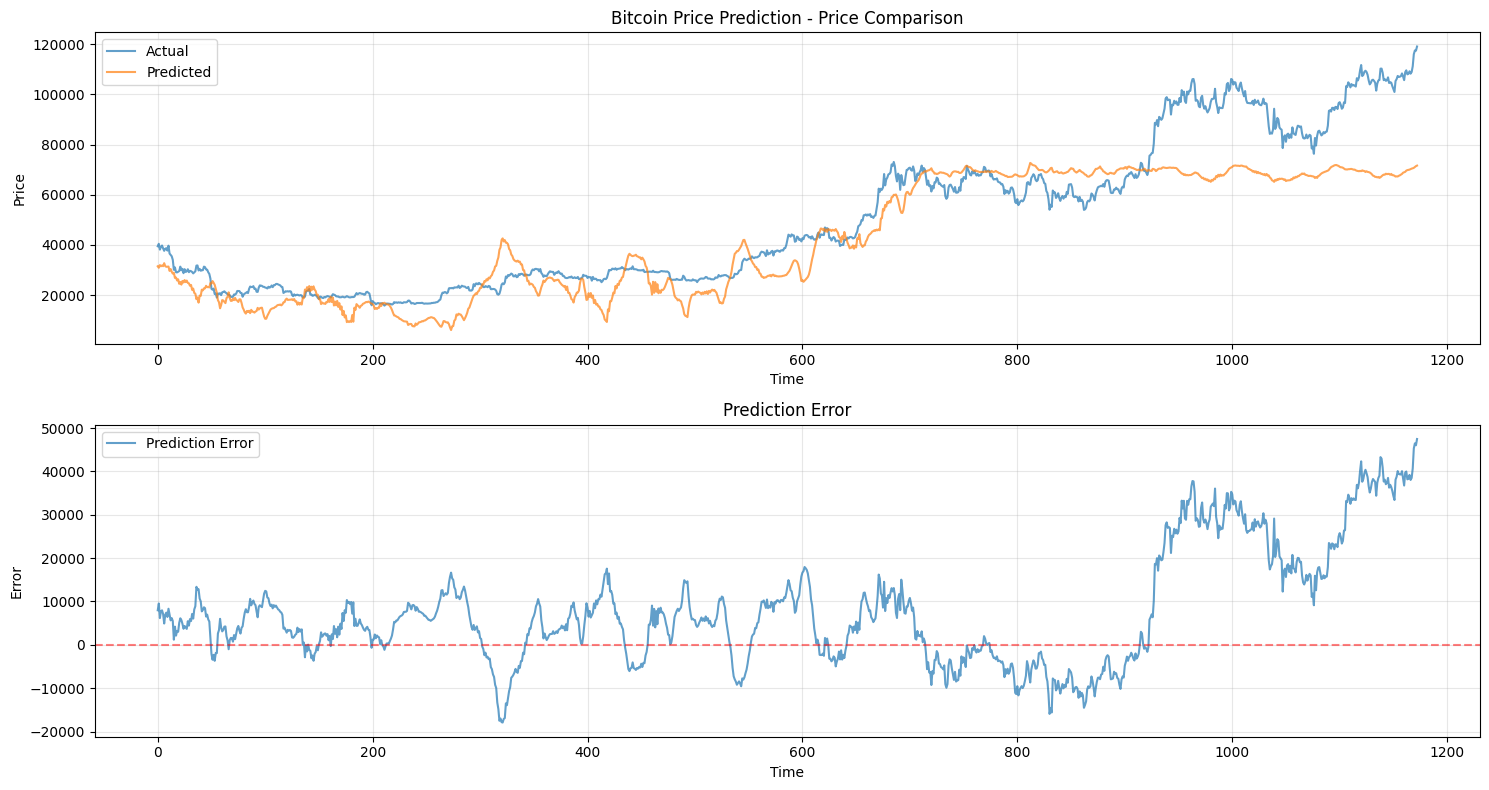

IndexError: list index out of range

In [29]:
from data_loader import load_all_data

predictor = BitcoinPricePredictor(lookback_window=60, prediction_horizon=1)
btc_ohlcv, daily_oi, daily_funding_rate, df_news = load_all_data()
print("Preparing features...")
df = predictor.prepare_features(btc_ohlcv, daily_funding_rate, daily_oi, df_news)

# Train model
print("Training model...")
history = predictor.train_model(df, target_col='close', epochs=100, batch_size=32)

# Make predictions
print("Making predictions...")
y_pred, y_true = predictor.predict(df)

# Evaluate model
print("Evaluating model...")
metrics = predictor.evaluate_model(y_true, y_pred)
print("Model Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot results
predictor.plot_results(y_true, y_pred)
predictor.plot_feature_importance()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()